In [1]:
!pip install pycaret
from pycaret.classification import *
!pip install catboost
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from datetime import date, timedelta
import time
from google.colab import drive
drive.mount('/content/drive')
import random
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_err = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_err2.csv')
train_qui = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_qui2.csv')
train_prob = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_prob2.csv')

test_err = pd.read_csv('/content/drive/Shareddrives/dacon/404/test_err2.csv')
test_qui = pd.read_csv('/content/drive/Shareddrives/dacon/404/test_qui2.csv')

In [4]:
path = '/content/drive/Shareddrives/dacon/404/preprocessed/mk2_with_categorized/'

test_err_42_counts = pd.read_csv(path + '테스트_에러_42항목별_카운트.csv', index_col=['Unnamed: 0'])
train_err_42_counts = pd.read_csv(path + '트레인_에러_42항목별_카운트.csv', index_col=['Unnamed: 0'])

# 얘는 넣어봐야 의미가 없어서... 일단 제외
test_err_code_frq = pd.read_csv(path + '테스트_에러_에러코드별_발생횟수.csv', index_col=['Unnamed: 0'])
train_err_code_frq = pd.read_csv(path +'트레인_에러_에러코드별_발생횟수.csv', index_col=['Unnamed: 0'])

test_err_sum_byday = pd.read_csv(path +'테스트_에러발생_일일누적합계.csv', index_col=['Unnamed: 0'])
train_err_sum_byday = pd.read_csv(path +'트레인_에러발생_일일누적합계.csv', index_col=['Unnamed: 0'])

# 얘도 넣어봐야 의미가 없어서... 일단 제외
test_qui_frq = pd.read_csv(path +'테스트_퀼리티_항목별_많이등장.csv', index_col=['Unnamed: 0'])
train_qui_frq = pd.read_csv(path +'트레인_퀼리티_항목별_많이등장.csv', index_col=['Unnamed: 0'])

test_qui_sum_byday = pd.read_csv(path +'테스트_퀼리티로그_일일수집합계.csv', index_col=['Unnamed: 0'])
train_qui_sum_byday = pd.read_csv(path +'트레인_퀼리티로그_일일수집합계.csv', index_col=['Unnamed: 0'])

test_qui_sum_byquality = pd.read_csv(path +'테스트_퀼리티_각각카테고리_합산.csv', index_col=['index'])
train_qui_sum_byquality = pd.read_csv(path +'트레인_퀼리티_각각카테고리_합산.csv', index_col=['index'])

test_2h = pd.read_csv(path +'테스트_err_2시간간격.csv', index_col=['Unnamed: 0'])
train_2h = pd.read_csv(path +'트레인_err_2시간간격.csv', index_col=['Unnamed: 0'])

train_6h = pd.read_csv(path + '트레인_err_6시간간격.csv', index_col=['Unnamed: 0'])
test_6h = pd.read_csv(path + '테스트_err_6시간간격.csv', index_col=['Unnamed: 0'])

train_12h = pd.read_csv(path + '트레인_err_12시간간격.csv', index_col=['Unnamed: 0'])
test_12h = pd.read_csv(path + '테스트_err_12시간간격.csv', index_col=['Unnamed: 0'])

In [5]:
train_time_series_6h = pd.read_csv(path + '트레인_err_시계열.csv', index_col=['Unnamed: 0'])
test_time_series_6h = pd.read_csv(path + '테스트_err_시계열.csv', index_col=['Unnamed: 0'])
train_time_series_6h.drop(['Group', 'problems'], axis = 1, inplace = True)

In [6]:
train_2h.rename(columns = lambda x: x + '_2', inplace = True)
test_2h.rename(columns = lambda x: x + '_2', inplace = True)

train_6h.rename(columns = lambda x: x + '_6', inplace = True)
test_6h.rename(columns = lambda x: x + '_6', inplace = True)

train_12h.rename(columns = lambda x: x + '_12', inplace = True)
test_12h.rename(columns = lambda x: x + '_12', inplace = True)

In [7]:
# 각 사용자가 42가지 에러타입을 몇 번씩 겪었는지 나타냄
train_err_42_counts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
10000,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0
10002,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10003,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0
10004,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,5.0,10.0,8.0,8.0,26.0,18.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,31.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,4.0
24996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24997,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,16.0,18.0,4.0,1.0,181.0,138.0,0.0,0.0,0.0,0.0,0.0,50.0,29.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,223.0,0.0,16.0,17.0,0.0,1.0,1.0,0.0,0.0,58.0,8.0,5.0
24998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0.0,1.0,51.0,12.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,14.0,0.0,15.0,12.0,0.0,1.0,1.0,0.0,0.0,6.0,0.0,0.0


In [8]:
# 각 사용자가 퀼리티 1 부터 퀼리티 12까지 자주 겪은 퀼리티 로그를 나타냄
# _1은 가장 자주 겪은 로그이며, _2는 두 번째로 자주 겪은 로그임. (None은 2번째 로그가 없음, 한 가지 오류만 겪음)
train_qui_frq

################ 이거는 카테고리 기준 등장빈도이며... 이를 확률로 치환하는 새로운 방법을 시도해본다.

,q1_1,q1_2,q2_1,q2_2,q5_1,q5_2,q6_1,q6_2,q7_1,q7_2,q8_1,q8_2,q9_1,q9_2,q10_1,q10_2,q11_1,q11_2,q12_1,q12_2
10000,0.0,None,0.0,None,0.0,4.0,0.0,None,0.0,None,0.0,None,0.0,None,7.0,4.0,0.0,None,0.0,None
10002,0.0,-1.0,0.0,-1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,None,0.0,1.0,3.0,5.0,0.0,-1.0,0.0,None
10004,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,1.0,0.0,0.0,None,0.0,None,1.0,3.0,0.0,-1.0,0.0,None
10005,0.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,0.0,None,0.0,None,4.0,5.0,0.0,-1.0,0.0,None
10006,0.0,None,0.0,None,0.0,4.0,0.0,1.0,0.0,1.0,0.0,None,0.0,None,4.0,None,0.0,None,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24990,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,None,0.0,None,0.0,None,1.0,None,0.0,-1.0,0.0,None
24992,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,None,0.0,None,0.0,None,5.0,3.0,0.0,-1.0,0.0,None
24993,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,None,0.0,None,0.0,None,5.0,3.0,0.0,-1.0,0.0,None
24995,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,None,0.0,None,0.0,None,3.0,2.0,0.0,-1.0,0.0,None


In [9]:
# 일단 자료들 날짜형식이나 콤마(,) 제거 등 간단한 전처리 진행

train_qui2 = train_qui.copy()
test_qui2 = test_qui.copy()
train_err2 = train_err.copy()
test_err2 = test_err.copy()

# 퀼리티 3,4는 값이 1밖에 없어서 의미가 없기 때문에 제외
# 펌웨어 버전은 이미 err 자료에 있기 때문에 중복으로 제외
# 퀼리티 0은 EDA 결과 퀼리티 2와 피어슨 상관계수 0.99를 보이기 때문에 0과 2 중에 하나만 골랐음
# 0의 결측치 Nan은 15%고 2의 결측치는 4%기 때문에 결측치가 적은 2를 남기고 0은 drop 시킨다.

## 퀼리티 6과 7도 0.81로 강한 상관관계를 보이고 있는데, 하나를 제외해야 하나 고민이 됨
train_qui2.drop(['fwver','quality_0', 'quality_3', 'quality_4'], axis =1, inplace=True)
test_qui2.drop(['fwver', 'quality_0', 'quality_3', 'quality_4'], axis =1, inplace=True)

test_qui2 = test_qui2.replace(',','', regex=True)
train_qui2 = train_qui2.replace(',','', regex=True)
test_qui2.loc[:,'quality_1':'quality_12'] = test_qui2.loc[:,'quality_1':'quality_12'].astype(float)
train_qui2.loc[:,'quality_1':'quality_12'] = train_qui2.loc[:,'quality_1':'quality_12'].astype(float)

train_qui2['time'] = pd.to_datetime(train_qui['time'], format = '%Y-%m-%d %H:%M:%S')
test_qui2['time'] = pd.to_datetime(test_qui['time'], format = '%Y-%m-%d %H:%M:%S')

train_err2['time'] = pd.to_datetime(train_err2['time'], format = '%Y-%m-%d %H:%M:%S')
test_err2['time'] = pd.to_datetime(test_err2['time'], format = '%Y-%m-%d %H:%M:%S')

train_err4 = train_err2.copy()
test_err4 = test_err2.copy()

In [10]:
# 퀼리티 임계치
# [-1, 0, 1] == -1 카테고리 -1, -1~0 =카테고리 0, 그 이상 = 카테고리 1
qualities = {}

qualities['quality_1'] = [-1,0, 1]
qualities['quality_2'] = [-1,0, 1]
qualities['quality_5'] = [-1,0,1,2,4, 10]
qualities['quality_6'] = [-1,0, 1]
qualities['quality_7'] = [0,1,100, 101]
qualities['quality_8'] = [0,1,2]
qualities['quality_9'] = [0,1,2]
qualities['quality_10'] = [0,1,2,3, 4, 5,7, 10 ,14,15] ##??
qualities['quality_11'] = [-1,0,1]
qualities['quality_12'] = [0,1,2]

## 모델 임계치
## 모델 0,1,2,3,4의 비율을 더하면 99.999% 이므로, 모델 5~8은 other model로 통합하는 것이 바람직 해 보임.

In [11]:
def quality_categorize(dataset):
  data = dataset.copy()
  for key in tqdm(qualities):
    intervals = qualities.get(key)
    for i in range(len(intervals)):
      if intervals[i] == intervals[-1]:
        data[key][data[key] >= intervals[i]] =  intervals[i]
      # elif intervals[i+1] - intervals[i] == 1:
      #   continue
      else:
        data[key][(data[key] >= intervals[i]) & (data[key] < intervals[i+1])] = intervals[i]
  return data

###### 그냥 쓰자니 불일치가 너무 많아서... 카테고리화 해서 확률로 전환한다.

train_qui3 = quality_categorize(train_qui2)
test_qui3 = quality_categorize(test_qui2)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
prob_list = list(set(train_prob.user_id))

train_qui3['problems'] = train_qui3.user_id.isin(prob_list)
train_qui3_tr = train_qui3[train_qui3['problems']].dropna()
train_qui3_fls = train_qui3[train_qui3['problems'] != True].dropna()

In [13]:
def probability(trainset, testset):
  train = trainset.copy()
  test = testset.copy()

  cols = list(train.loc[:,'quality_1':'quality_12'].columns)

  train['problems'] = train.user_id.isin(prob_list)
  train_tr = train[train['problems']]
  train_fls = train[train['problems'] != True]


  for col in tqdm(cols):
    temp_ori = train[col].value_counts()
    temp_tr = train_tr[col].value_counts()
    temp_fls = train_fls[col].value_counts()

    ori = pd.DataFrame(temp_ori)
    tr = pd.DataFrame(temp_tr)

    probs = tr/ori
    for ind in list(probs.index):
      train[col][train[col] == ind] = probs.loc[ind,:].values[0]
      test[col][test[col] == ind] = probs.loc[ind,:].values[0]
  train.drop(['problems'], axis = 1, inplace = True)
  return train, test, probs

In [14]:
train_qui_prob, test_qui_prob, prob = probability(train_qui3, test_qui3)

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
# 일단 확률로 바꾼 값들을 같은 ID끼리 평균으로 묶는다.

train_qui_probs = train_qui_prob.groupby(by = 'user_id').mean()
test_qui_probs = test_qui_prob.groupby(by = 'user_id').mean()

In [16]:
#################### test_qui_frq 대신에 이걸 넣자. ########################
########## 넣어봤는데 그닥... 이번에는 단순 합계를 넣어보자  test_qui_sum_byquality


test_qui_probs

,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
user_id,,,,,,,,,,
30000,0.453202,0.470339,0.399646,0.456372,0.478145,0.463237,0.470470,0.390104,0.453996,0.468568
30001,0.471144,0.491062,0.449704,0.471127,0.465027,0.463237,0.470470,0.476673,0.471726,0.468568
30002,0.462173,0.480701,0.428165,0.462095,0.465027,0.463237,0.470470,0.490867,0.462861,0.468568
30003,0.453202,0.470339,0.399759,0.456372,0.472898,0.463237,0.470470,0.338923,0.453996,0.468568
30004,0.471144,0.491062,0.429772,0.474437,0.478145,0.463237,0.470470,0.366937,0.471726,0.468568
...,...,...,...,...,...,...,...,...,...,...
44990,0.461177,0.479549,0.429800,0.461092,0.465027,0.463237,0.470470,0.487934,0.461876,0.468568
44993,0.456193,0.475545,0.408818,0.459383,0.471586,0.463237,0.442244,0.402184,0.456951,0.468568
44994,0.518989,0.546323,0.520579,0.519299,0.465027,0.463237,0.470470,0.390104,0.519006,0.468568


In [17]:
### 펌웨어의 확률을 구하는 함수 ###
## 유진's 코드를 참조하여 좀더 빠르게 구동되도록 수정함.

def fw_probs(traindata, testdata):
  
  train_temp = traindata.drop_duplicates(subset = 'user_id')
  test_temp = testdata.drop_duplicates(subset = 'user_id')
  

  test_list = []
  train_temp['problems'] = train_temp['user_id'].isin(prob_list)
  train_tr = train_temp[train_temp['problems']]
  train_fls = train_temp[train_temp['problems'] != True]

  new_fw = ['03.11', '04.16', '04.22', '04.33', '04.73', '04.82', '05.15', '05.66', '8.5', '10']

  for fw in tqdm(new_fw):
    if fw == '10':
      ori = len(train_temp[(train_temp['fwver'].str.contains(fw)) & ~(train_temp['fwver'].str.contains('104')) & ~(train_temp['fwver'].str.contains('109'))])
      tr = len(train_tr[(train_tr['fwver'].str.contains(fw)) & ~(train_tr['fwver'].str.contains('104')) & ~(train_tr['fwver'].str.contains('109'))])
      fls = len(train_fls[(train_temp['fwver'].str.contains(fw)) & ~(train_fls['fwver'].str.contains('104')) & ~(train_fls['fwver'].str.contains('109'))])
      fw_st = [ori, tr, fls, tr/ori]
      test_list.append(fw_st)
    else:
      ori = len(train_temp[train_temp['fwver'].str.contains(fw)])
      tr = len(train_tr[train_tr['fwver'].str.contains(fw)])
      fls = len(train_fls[train_fls['fwver'].str.contains(fw)])
      fw_st = [ori, tr, fls, tr/ori]
      test_list.append(fw_st)

  fw_df = pd.DataFrame(test_list, index = new_fw, columns = ['원본', '불만고객', '고객', '불만확률'])

  train_temp['fw_prob'] = 0
  test_temp['fw_prob'] = 0

  for fw in tqdm(new_fw):
    if fw == '10':
      train_temp['fw_prob'][(train_temp['fwver'].str.contains(fw)) & ~(train_temp['fwver'].str.contains('104')) & ~(train_temp['fwver'].str.contains('109'))] = fw_df.loc[fw][3]
      test_temp['fw_prob'][(test_temp['fwver'].str.contains(fw)) & ~(test_temp['fwver'].str.contains('104')) & ~(test_temp['fwver'].str.contains('109'))] = fw_df.loc[fw][3]
    else:
      train_temp['fw_prob'][train_temp['fwver'].str.contains(fw)] = fw_df.loc[fw][3]
      test_temp['fw_prob'][test_temp['fwver'].str.contains(fw)] = fw_df.loc[fw][3]
  df = train_temp.loc[:,['user_id', 'fw_prob']]
  df_t = test_temp.loc[:,['user_id', 'fw_prob']]

  df.set_index('user_id', inplace = True)
  df_t.set_index('user_id', inplace = True)

  return df, df_t

In [18]:
train_fw, test_fw = fw_probs(train_err2, test_err2)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
# Error 데이터를 일일 단위로 쪼개서 각 사용자가 날짜별로 겪은 에러코드의 누계
# 0일은 10월 31일, 마지막은 11월 30일
train_err_sum_byday

,er_sum_0,er_sum_1,er_sum_2,er_sum_3,er_sum_4,er_sum_5,er_sum_6,er_sum_7,er_sum_8,er_sum_9,er_sum_10,er_sum_11,er_sum_12,er_sum_13,er_sum_14,er_sum_15,er_sum_16,er_sum_17,er_sum_18,er_sum_19,er_sum_20,er_sum_21,er_sum_22,er_sum_23,er_sum_24,er_sum_25,er_sum_26,er_sum_27,er_sum_28,er_sum_29,er_sum_30
10000,0,11,20,38,43,53,62,82,89,94,104,118,123,140,149,165,174,182,199,218,223,230,235,240,245,254,265,277,295,308,317
10001,0,11,61,90,138,180,209,222,246,299,351,374,413,421,462,486,501,531,556,583,628,653,671,689,716,727,785,2237,2275,2337,2365
10002,0,10,23,36,51,60,68,85,96,108,118,129,140,145,160,173,188,193,202,217,222,232,248,251,257,268,273,289,289,297,306
10003,0,9,23,33,38,54,59,61,72,77,96,120,126,132,134,136,151,157,164,179,184,191,212,223,240,246,254,275,286,300,306
10004,0,25,46,95,123,134,162,180,209,229,283,302,323,340,360,375,390,408,449,457,559,587,603,621,644,671,690,714,732,755,777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,41,58,76,76,100,103,133,155,172,194
24996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
24997,0,9,43,77,141,163,194,218,248,274,292,301,320,339,377,408,418,445,464,496,525,550,579,621,654,695,718,748,779,813,826
24998,0,7,7,17,17,24,24,32,32,39,76,83,83,89,91,96,102,102,111,112,118,120,125,131,131,137,137,144,144,151,155


In [20]:
# Quality 데이터를 일일 단위로 쪼개서 퀼리티 로그가 사용자 별로 몇 번 수집되었나
# 누적, 마지막 11월 30일 자료는 최종 몇 번의 로그 수집이 있었는가를 의미함.
train_qui_sum_byday

,q_sum_0,q_sum_1,q_sum_2,q_sum_3,q_sum_4,q_sum_5,q_sum_6,q_sum_7,q_sum_8,q_sum_9,q_sum_10,q_sum_11,q_sum_12,q_sum_13,q_sum_14,q_sum_15,q_sum_16,q_sum_17,q_sum_18,q_sum_19,q_sum_20,q_sum_21,q_sum_22,q_sum_23,q_sum_24,q_sum_25,q_sum_26,q_sum_27,q_sum_28,q_sum_29,q_sum_30
10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
10002,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,8.0
10004,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
10006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
24992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
24993,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
24995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0


In [21]:
# train_err_42_counts, train_err_code_frq, train_qui_frq, train_err_sum_byday, train_qui_sum_byday
# test_err3, test_err_42_counts, test_err_code_frq, test_qui_frq, test_err_sum_byday, test_qui_sum_byday
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
robust = RobustScaler()
robust_q = RobustScaler()
robust_nq = RobustScaler()
minmax = MinMaxScaler()

In [22]:
test_qui_frq = test_qui_frq.astype(str)
train_qui_frq = train_qui_frq.astype(str)

In [23]:
# 24시간을 단순하게 평균내면, 23시와 1시의 평균이 이상해지기 때문에(실제로는 2시간 차이인데, 산술적으로 22시간 차이로 잡힘)
# 태양광 때 처럼 일단 코사인 시간으로 바꿔서 평균, 분산, 최빈값을 구한다.

def cos_time(dataset):
  dataset['cos_time'] = np.cos(2*np.pi*dataset.hour/24)
  dataset['sin_time'] = np.sin(2*np.pi*dataset.hour/24)
  return dataset

def cos_stats(dataset):
  dataset['hour'] = dataset['time'].dt.hour
  data = cos_time(dataset)[['user_id', 'cos_time', 'sin_time']]
  cols = []
  temp = data.groupby(by = 'user_id')

  a = temp['cos_time'].mean()
  cols += ['cos_mean']
  b = temp['cos_time'].std()
  cols += ['cos_std']

  c = temp['sin_time'].mean()
  cols += ['sin_mean']
  d = temp['sin_time'].std()
  cols += ['sin_std']

  df = pd.concat([a,b,c,d], axis = 1) 
  df.columns = cols
  return df

In [24]:
cos_train = cos_stats(train_err4)
cos_test = cos_stats(test_err4)

In [25]:
cos_test

,cos_mean,cos_std,sin_mean,sin_std
user_id,,,,
30000,0.087315,0.587431,-0.482636,0.643926
30001,-0.008207,0.684306,0.059167,0.729163
30002,-0.088347,0.631359,-0.002706,0.771122
30003,0.079423,0.656741,-0.008234,0.751665
30004,-0.003992,0.687212,0.059433,0.724792
...,...,...,...,...
44994,-0.102470,0.684066,-0.355426,0.629286
44995,0.042984,0.769687,-0.180729,0.612331
44996,-0.000892,0.653807,-0.260090,0.710849


In [26]:
# errtype 1~42까지 확률로 치환하기.

def errtype_to_prob(trainset, testset):
  data = trainset.copy()
  t_data = testset.copy()
  data['problems'] = data['user_id'].isin(prob_list)
  one_hot = pd.get_dummies(data['errtype'])

  temp = data['problems']
  temp2 = pd.concat([temp, one_hot], axis = 1)

  temp2_tr = temp2[temp2['problems']].fillna(0)
  temp2_fls = temp2[temp2['problems'] != True].fillna(0)

  trues = pd.DataFrame(temp2_tr.sum()).transpose()
  falses = pd.DataFrame(temp2_fls.sum()).transpose()
  tru = trues.drop('problems', axis = 1)
  fls = falses.drop('problems', axis = 1)
  rslt = tru/(tru+fls)
  er_list = list(set(data.errtype))
  er_list.sort()
  for er in tqdm(er_list):
    data.errtype[data['errtype'] == er] =rslt.loc[0,er]
    t_data.errtype[t_data['errtype'] == er] =rslt.loc[0,er]
  return data, t_data

In [27]:
train, test = errtype_to_prob(train_err2, test_err2)

  0%|          | 0/41 [00:00<?, ?it/s]

In [28]:
train_errtype_prob = train.groupby(by = 'user_id').mean()[['errtype']]
test_errtype_prob = test.groupby(by = 'user_id').mean()[['errtype']]

In [29]:
# 중간에 펌웨어 업데이트를 한 경우에 1, 아니면 0으로 표시하는 함수 

def update(dataset):

  data = dataset.copy()
  ids = list(set(data.user_id))
  ids.sort()
  print('1/3')
  data.replace({'fwver': np.nan}, {'fwver': '00.00.0000'}, inplace = True)
  data.replace({'fwver': '8.5.3'}, {'fwver': '08.05.3000'}, inplace = True)
  data.replace({'fwver': '10'}, {'fwver': '10.00.0000'}, inplace = True)
  data['fwver'] = data['fwver'].str.replace('\.','', regex = True)
  print('2/3')
  data = data.astype({'fwver': 'int'})
  fw_list = data.fwver.unique()
  data2 = data.groupby(by = 'user_id').mean()
  print('3/3')
  data2['fw_update'] = data2['fwver'].isin(fw_list)
  data2['fw_update'] = data2['fw_update'].astype(int)
  df = data2.loc[:,['fw_update']]
  return df

In [30]:
fw_update_train = update(train_err2)
fw_update_test = update(test_err2)

1/3
2/3
3/3
1/3
2/3
3/3


In [31]:
train_err3 = train_err2[['user_id', 'errtype', 'errcode', 'time']]
test_err3 = test_err2[['user_id', 'errtype', 'errcode', 'time']]

# 상위 15개 리스트
err_code =['1','0','connection timeout','B-A8002','80','79','14','active','2','84','85','standby','NFANDROID2','connection fail to establish','3']

# 위의 15개에 포함되지 않는 에러코드는 걍 'etc'로 분류
train_err3['errcode'][~train_err3['errcode'].isin(err_code)] = 'ETC'
test_err3['errcode'][~test_err3['errcode'].isin(err_code)] = 'ETC'

In [32]:
dummi = pd.get_dummies(train_err3['errcode'], prefix = 'Err_code_')
id = train_err3[['user_id']]
train_types = pd.concat([id, dummi], axis =1)

dummi = pd.get_dummies(test_err3['errcode'], prefix = 'Err_code_')
id = test_err3[['user_id']]
test_types = pd.concat([id, dummi], axis =1)

In [33]:
test_err_types = test_types.groupby(by ='user_id').sum()
train_err_types = train_types.groupby(by ='user_id').sum()

In [34]:
# 시계열 자료를 활용해 군집화.
ks = KMeans(n_clusters = 7, random_state = 42)
ks.fit(train_time_series_6h)
train_time_series_6h['Group'] = ks.predict(train_time_series_6h)
test_time_series_6h['Group'] = ks.predict(test_time_series_6h)
# train_time_series_6h['problems'] = train_time_series_6h.index.isin(prob_list)

In [35]:
train_time_series_6h

,2020-10-31 18:00:00,2020-11-01 00:00:00,2020-11-01 06:00:00,2020-11-01 12:00:00,2020-11-01 18:00:00,2020-11-02 00:00:00,2020-11-02 06:00:00,2020-11-02 12:00:00,2020-11-02 18:00:00,2020-11-03 00:00:00,2020-11-03 06:00:00,2020-11-03 12:00:00,2020-11-03 18:00:00,2020-11-04 00:00:00,2020-11-04 06:00:00,2020-11-04 12:00:00,2020-11-04 18:00:00,2020-11-05 00:00:00,2020-11-05 06:00:00,2020-11-05 12:00:00,2020-11-05 18:00:00,2020-11-06 00:00:00,2020-11-06 06:00:00,2020-11-06 12:00:00,2020-11-06 18:00:00,2020-11-07 00:00:00,2020-11-07 06:00:00,2020-11-07 12:00:00,2020-11-07 18:00:00,2020-11-08 00:00:00,2020-11-08 06:00:00,2020-11-08 12:00:00,2020-11-08 18:00:00,2020-11-09 00:00:00,2020-11-09 06:00:00,2020-11-09 12:00:00,2020-11-09 18:00:00,2020-11-10 00:00:00,2020-11-10 06:00:00,2020-11-10 12:00:00,2020-11-10 18:00:00,2020-11-11 00:00:00,2020-11-11 06:00:00,2020-11-11 12:00:00,2020-11-11 18:00:00,2020-11-12 00:00:00,2020-11-12 06:00:00,2020-11-12 12:00:00,2020-11-12 18:00:00,2020-11-13 00:00:00,2020-11-13 06:00:00,2020-11-13 12:00:00,2020-11-13 18:00:00,2020-11-14 00:00:00,2020-11-14 06:00:00,2020-11-14 12:00:00,2020-11-14 18:00:00,2020-11-15 00:00:00,2020-11-15 06:00:00,2020-11-15 12:00:00,2020-11-15 18:00:00,2020-11-16 00:00:00,2020-11-16 06:00:00,2020-11-16 12:00:00,2020-11-16 18:00:00,2020-11-17 00:00:00,2020-11-17 06:00:00,2020-11-17 12:00:00,2020-11-17 18:00:00,2020-11-18 00:00:00,2020-11-18 06:00:00,2020-11-18 12:00:00,2020-11-18 18:00:00,2020-11-19 00:00:00,2020-11-19 06:00:00,2020-11-19 12:00:00,2020-11-19 18:00:00,2020-11-20 00:00:00,2020-11-20 06:00:00,2020-11-20 12:00:00,2020-11-20 18:00:00,2020-11-21 00:00:00,2020-11-21 06:00:00,2020-11-21 12:00:00,2020-11-21 18:00:00,2020-11-22 00:00:00,2020-11-22 06:00:00,2020-11-22 12:00:00,2020-11-22 18:00:00,2020-11-23 00:00:00,2020-11-23 06:00:00,2020-11-23 12:00:00,2020-11-23 18:00:00,2020-11-24 00:00:00,2020-11-24 06:00:00,2020-11-24 12:00:00,2020-11-24 18:00:00,2020-11-25 00:00:00,2020-11-25 06:00:00,2020-11-25 12:00:00,2020-11-25 18:00:00,2020-11-26 00:00:00,2020-11-26 06:00:00,2020-11-26 12:00:00,2020-11-26 18:00:00,2020-11-27 00:00:00,2020-11-27 06:00:00,2020-11-27 12:00:00,2020-11-27 18:00:00,2020-11-28 00:00:00,2020-11-28 06:00:00,2020-11-28 12:00:00,2020-11-28 18:00:00,2020-11-29 00:00:00,2020-11-29 06:00:00,2020-11-29 12:00:00,2020-11-29 18:00:00,2020-11-30 00:00:00,2020-11-30 06:00:00,2020-11-30 12:00:00,2020-11-30 18:00:00,2020-12-01 00:00:00,2020-12-01 06:00:00,2020-12-01 12:00:00,2020-12-01 18:00:00,2020-12-02 00:00:00,2020-12-02 06:00:00,2020-12-02 12:00:00,2020-12-02 18:00:00,Group
10000,-0.63093,0.315465,-0.315465,0.000000,-0.630930,0.184535,-0.315465,-0.630930,0.000000,0.315465,-0.315465,0.460399,-0.630930,-0.630930,-0.630930,0.101557,-0.315465,0.254692,-0.315465,-0.630930,0.000000,0.369070,-0.315465,-0.630930,-0.630930,-0.130930,0.460399,0.101557,0.101557,0.101557,0.000000,-0.630930,-0.630930,-0.130930,0.000000,-0.630930,-0.630930,0.417022,-0.315465,-0.630930,-0.630930,0.500000,0.000000,-0.630930,-0.630930,-0.315465,-0.315465,-0.630930,0.000000,0.417022,0.000000,0.184535,-0.630930,-0.130930,0.000000,0.101557,-0.630930,0.536429,0.101557,-0.630930,-0.630930,0.184535,-0.315465,-0.630930,0.000000,0.315465,-0.315465,-0.630930,-0.630930,0.184535,0.000000,0.417022,-0.630930,-0.315465,0.101557,0.254692,0.369070,-0.315465,0.101557,-0.630930,-0.630930,0.000000,0.101557,-0.630930,-0.630930,-0.315465,0.101557,-0.630930,-0.630930,-0.315465,0.101557,-0.630930,-0.630930,-0.315465,0.101557,-0.630930,-0.630930,0.184535,-0.315465,-0.630930,0.000000,0.315465,-0.315465,-0.630930,0.000000,0.315465,-0.315465,-0.630930,0.101557,0.369070,-0.315465,-0.630930,0.417022,0.315465,0.254692,-0.630930,-0.630930,0.101557,-0.315465,-0.630930,0.101557,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,0
10001,-0.63093,0.369070,-0.630930,-0.630930,0.000000,0.709142,0.536429,0.536429,0.369070,-0.315465,0.630930,0.315465,0.254692,-0.130930,0.901593,-0.630930,0.709142,0.570157,-0.63

In [36]:
def multi_model(dataset):
  data = dataset.copy()
  #ids = [x for x in range(10000,12000)]
  ids = data.user_id.unique()
  ids.sort()

  models = []

  for id in tqdm(ids):
    temp = data[data['user_id'] == id]
    mul = len(temp.model_nm.unique())
    if mul == 1:
      models.append('one')
    else:
      models.append('multi')
    
  df = pd.DataFrame(models, index = ids, columns = ['multi_model'])

  return df

# tt = train_err2[train_err2.user_id == 10001]
# len(tt.fwver.unique())

In [37]:
train_multi_model = multi_model(train_err2)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [53]:
# trainset = pd.concat([train_fw, train_err_42_counts,train_err_types, train_qui_sum_byday, train_err_sum_byday, train_qui_probs, cos_train, train_errtype_prob, fw_update_train, train_2h], axis = 1) #train_err_sum_byday, train_qui_sum_byquality
# testset = pd.concat([test_fw, test_err_42_counts, test_err_types, test_qui_sum_byday, test_err_sum_byday,test_qui_probs, cos_test, test_errtype_prob, fw_update_test, test_2h], axis = 1) #test_err_sum_byday, test_qui_sum_byquality, test_qui_probs
# train_err_time_stat_2h
# test_err_time_stat_2h
# trainset.reset_index(inplace=True)
# testset.reset_index(inplace=True)
# trainset = trainset.dropna(axis = 1)
# testset = testset.dropna(axis = 1)
# trainset = trainset.drop(['model_nm', 'fwver'], axis = 1)
# testset = testset.drop(['model_nm','fwver'], axis = 1)

In [38]:
# quantile = 0.03

# trainset_w = trainset.copy()
# testset_w = testset.copy()
# train_temp = trainset_w.loc[:,'0':'er_sum_30']
# test_temp = testset_w.loc[:,'0':'er_sum_30']

# trainset_w.loc[:,'0':'er_sum_30'] = pd.DataFrame(winsorize(train_temp, limits = [quantile,quantile], axis = 1), index = train_temp.index, columns = train_temp.columns)
# testset_w.loc[:,'0':'er_sum_30'] = pd.DataFrame(winsorize(test_temp, limits = [quantile,quantile], axis = 1), index = test_temp.index, columns = test_temp.columns)

In [39]:
# trainset2 = np.log(trainset_w + 2)
# testset2 = np.log(testset_w + 2)

In [40]:
def nan_to_mean(dataset):
  data = dataset.copy()  
  col_list = list(dataset.columns)

  for col in tqdm(col_list):
    temp = data[col]
    val = temp.mean()
    val_list = []
    for id in range(45000):
      a = random.uniform(0.985,1.015)
      val_list.append(val * a)
    temp.fillna(value = pd.Series(val_list), inplace=True)
    data[col] = temp
  return data

In [59]:
test_err3

,user_id,errtype,errcode,time
0,30000,31,1,2020-11-01 03:02:27
1,30000,33,2,2020-11-01 03:02:27
2,30000,15,1,2020-11-01 03:02:28
3,30000,22,1,2020-11-01 03:02:56
4,30000,11,1,2020-11-01 03:03:00
...,...,...,...,...
16532643,44998,40,0,2020-11-30 21:00:50
16532644,44998,31,1,2020-11-30 21:18:31
16532645,44998,15,1,2020-11-30 21:18:32
16532646,44998,16,1,2020-11-30 21:22:59


In [41]:
# trainset2 = nan_to_mean(trainset)
# testset2 = nan_to_mean(testset)

# trainset2 = trainset.fillna(0)
# testset2 = testset.fillna(0)

# trainset2 = trainset.copy()
# testset2 = testset.copy()

In [144]:
train_time_series_6h

,2020-10-31 18:00:00,2020-11-01 00:00:00,2020-11-01 06:00:00,2020-11-01 12:00:00,2020-11-01 18:00:00,2020-11-02 00:00:00,2020-11-02 06:00:00,2020-11-02 12:00:00,2020-11-02 18:00:00,2020-11-03 00:00:00,2020-11-03 06:00:00,2020-11-03 12:00:00,2020-11-03 18:00:00,2020-11-04 00:00:00,2020-11-04 06:00:00,2020-11-04 12:00:00,2020-11-04 18:00:00,2020-11-05 00:00:00,2020-11-05 06:00:00,2020-11-05 12:00:00,2020-11-05 18:00:00,2020-11-06 00:00:00,2020-11-06 06:00:00,2020-11-06 12:00:00,2020-11-06 18:00:00,2020-11-07 00:00:00,2020-11-07 06:00:00,2020-11-07 12:00:00,2020-11-07 18:00:00,2020-11-08 00:00:00,2020-11-08 06:00:00,2020-11-08 12:00:00,2020-11-08 18:00:00,2020-11-09 00:00:00,2020-11-09 06:00:00,2020-11-09 12:00:00,2020-11-09 18:00:00,2020-11-10 00:00:00,2020-11-10 06:00:00,2020-11-10 12:00:00,...,2020-11-23 06:00:00,2020-11-23 12:00:00,2020-11-23 18:00:00,2020-11-24 00:00:00,2020-11-24 06:00:00,2020-11-24 12:00:00,2020-11-24 18:00:00,2020-11-25 00:00:00,2020-11-25 06:00:00,2020-11-25 12:00:00,2020-11-25 18:00:00,2020-11-26 00:00:00,2020-11-26 06:00:00,2020-11-26 12:00:00,2020-11-26 18:00:00,2020-11-27 00:00:00,2020-11-27 06:00:00,2020-11-27 12:00:00,2020-11-27 18:00:00,2020-11-28 00:00:00,2020-11-28 06:00:00,2020-11-28 12:00:00,2020-11-28 18:00:00,2020-11-29 00:00:00,2020-11-29 06:00:00,2020-11-29 12:00:00,2020-11-29 18:00:00,2020-11-30 00:00:00,2020-11-30 06:00:00,2020-11-30 12:00:00,2020-11-30 18:00:00,2020-12-01 00:00:00,2020-12-01 06:00:00,2020-12-01 12:00:00,2020-12-01 18:00:00,2020-12-02 00:00:00,2020-12-02 06:00:00,2020-12-02 12:00:00,2020-12-02 18:00:00,Group
10000,-0.63093,0.315465,-0.315465,0.000000,-0.630930,0.184535,-0.315465,-0.630930,0.000000,0.315465,-0.315465,0.460399,-0.630930,-0.630930,-0.630930,0.101557,-0.315465,0.254692,-0.315465,-0.630930,0.000000,0.369070,-0.315465,-0.630930,-0.630930,-0.130930,0.460399,0.101557,0.101557,0.101557,0.000000,-0.630930,-0.630930,-0.130930,0.000000,-0.630930,-0.630930,0.417022,-0.315465,-0.630930,...,0.101557,-0.630930,-0.630930,-0.315465,0.101557,-0.630930,-0.630930,0.184535,-0.315465,-0.630930,0.000000,0.315465,-0.315465,-0.630930,0.000000,0.315465,-0.315465,-0.630930,0.101557,0.369070,-0.315465,-0.630930,0.417022,0.315465,0.254692,-0.630930,-0.630930,0.101557,-0.315465,-0.630930,0.101557,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,0
10001,-0.63093,0.369070,-0.630930,-0.630930,0.000000,0.709142,0.536429,0.536429,0.369070,-0.315465,0.630930,0.315465,0.254692,-0.130930,0.901593,-0.630930,0.709142,0.570157,-0.630930,0.658521,0.570157,0.101557,0.184535,0.658521,0.101557,0.254692,-0.630930,0.101557,0.000000,0.000000,-0.630930,0.369070,0.570157,0.775864,-0.630930,0.184535,0.885622,0.684535,0.184535,0.684535,...,-0.630930,0.369070,0.000000,0.184535,0.315465,0.184535,0.460399,-0.130930,0.101557,-0.315465,0.101557,0.369070,0.658521,0.601557,0.754692,-0.630930,0.796095,2.433031,2.275097,0.254692,0.417022,0.315465,0.658521,0.709142,0.709142,0.684535,0.417022,0.500000,0.101557,0.184535,0.369070,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,2
10002,-0.63093,-0.130930,0.101557,-0.630930,0.101557,-0.315465,0.254692,-0.315465,0.184535,0.000000,-0.630930,-0.630930,0.460399,-0.315465,0.101557,0.184535,0.184535,-0.130930,0.000000,-0.315465,0.000000,0.101557,-0.315465,-0.630930,0.000000,0.000000,0.254692,0.254692,-0.130930,-0.315465,-0.630930,0.254692,0.101557,0.000000,0.369070,-0.315465,-0.630930,-0.630930,-0.630930,0.184535,...,-0.630930,-0.630930,-0.630930,-0.630930,-0.630930,-0.630930,0.254692,0.000000,0.184535,-0.630930,0.000000,-0.315465,-0.630930,-0.630930,0.101557,0.315465,0.184535,-0.630930,0.101557,-0.630930,-0.630930,-0.630930,-0.630930,-0.130930,0.101557,-0.630930,-0.130930,-0.315465,0.101557,-0.315465,0.000000,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,1
10003,-0.63093,-0.630930,-0.630930,-0.630930,0.417022,0.254692,0.101557,-0.630930,0.101557,0.101557,0.000000,-0.630930,0.000000,-0.630930,-0.130930,-0

In [124]:
#  trainset2 = np.log(trainset + 2)
#  testset2 = np.log(testset + 2)

trainset = pd.concat([train_fw, train_err_42_counts, train_err_types, train_err_sum_byday, train_qui_probs, cos_train, train_errtype_prob, fw_update_train, train_2h], axis = 1)
testset = pd.concat([test_fw, test_err_42_counts, test_err_types, test_err_sum_byday,test_qui_probs, cos_test, test_errtype_prob, fw_update_test, test_2h], axis = 1)

trainset2 = pd.DataFrame(robust.fit_transform(trainset), index = trainset.index, columns=trainset.columns)

trainset3 = pd.concat([trainset2, train_time_series_6h, train_multi_model], axis = 1)
# testset3 = pd.concat([testset2, train_time_series_6h], axis = 1)

In [126]:
trainset3.reset_index(inplace=True)
probs = list(set(train_prob.user_id))
trainset3['TARGET'] = trainset3['index'].apply(lambda x: 1 if x in probs else 0)
trainset3.set_index('index', inplace = True)

num = list(trainset3.columns)
num.remove('TARGET')
num.remove('Group')
num.remove('multi_model')

In [127]:
trainset3

,fw_prob,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,2020-11-23 18:00:00,2020-11-24 00:00:00,2020-11-24 06:00:00,2020-11-24 12:00:00,2020-11-24 18:00:00,2020-11-25 00:00:00,2020-11-25 06:00:00,2020-11-25 12:00:00,2020-11-25 18:00:00,2020-11-26 00:00:00,2020-11-26 06:00:00,2020-11-26 12:00:00,2020-11-26 18:00:00,2020-11-27 00:00:00,2020-11-27 06:00:00,2020-11-27 12:00:00,2020-11-27 18:00:00,2020-11-28 00:00:00,2020-11-28 06:00:00,2020-11-28 12:00:00,2020-11-28 18:00:00,2020-11-29 00:00:00,2020-11-29 06:00:00,2020-11-29 12:00:00,2020-11-29 18:00:00,2020-11-30 00:00:00,2020-11-30 06:00:00,2020-11-30 12:00:00,2020-11-30 18:00:00,2020-12-01 00:00:00,2020-12-01 06:00:00,2020-12-01 12:00:00,2020-12-01 18:00:00,2020-12-02 00:00:00,2020-12-02 06:00:00,2020-12-02 12:00:00,2020-12-02 18:00:00,Group,multi_model,TARGET
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000,-0.412725,0.0,0.0,8.0,26.00,-0.20,0.5,0.0,0.0,0.0,7.0,0.000000,0.25,1.0,2.25,-0.530120,-0.214286,0.0,0.0,0.0,0.0,0.0,-0.475410,-0.254335,0.0,0.0,-0.178571,1.0,1.0,0.0,0.0,-0.610,0.0,-0.8750,0.0,0.0,-1.0,-1.0,0.0,0.0,...,-0.630930,-0.315465,0.101557,-0.630930,-0.630930,0.184535,-0.315465,-0.630930,0.000000,0.315465,-0.315465,-0.630930,0.000000,0.315465,-0.315465,-0.630930,0.101557,0.369070,-0.315465,-0.630930,0.417022,0.315465,0.254692,-0.630930,-0.630930,0.101557,-0.315465,-0.630930,0.101557,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,0,one,0
10001,0.000000,0.0,0.0,0.0,0.00,2.45,0.5,0.0,0.0,0.0,0.0,-1.666667,-1.00,1.0,3.50,0.578313,0.742857,0.0,4.0,1.0,3.0,1.0,11.918033,17.109827,5.0,1.0,-0.535714,0.0,0.0,0.0,0.0,0.640,0.0,-0.2500,18.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.184535,0.315465,0.184535,0.460399,-0.130930,0.101557,-0.315465,0.101557,0.369070,0.658521,0.601557,0.754692,-0.630930,0.796095,2.433031,2.275097,0.254692,0.417022,0.315465,0.658521,0.709142,0.709142,0.684535,0.417022,0.500000,0.101557,0.184535,0.369070,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,2,one,1
10002,-0.412725,0.0,0.0,2.0,33.00,-0.15,1.0,0.0,0.0,0.0,1.0,-0.666667,-0.25,1.0,0.75,-0.614458,-0.342857,0.0,0.0,0.0,0.0,0.0,-0.475410,-0.254335,2.0,0.0,-0.428571,2.0,2.0,0.0,0.0,-0.610,0.0,-0.8750,0.0,0.0,-1.0,-1.0,0.0,0.0,...,-0.630930,-0.630930,-0.630930,-0.630930,0.254692,0.000000,0.184535,-0.630930,0.000000,-0.315465,-0.630930,-0.630930,0.101557,0.315465,0.184535,-0.630930,0.101557,-0.630930,-0.630930,-0.630930,-0.630930,-0.130930,0.101557,-0.630930,-0.130930,-0.315465,0.101557,-0.315465,0.000000,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,1,one,0
10003,0.000000,0.0,0.0,0.0,0.00,-0.10,0.5,0.0,0.0,0.0,0.0,-2.000000,-1.50,0.0,-0.25,-0.614458,-0.657143,0.5,0.0,0.0,0.0,0.0,-0.016393,0.184971,0.0,0.0,0.785714,0.0,0.0,0.0,0.0,-0.285,0.0,-0.3750,0.0,0.0,0.0,0.0,2.0,0.0,...,0.000000,0.570157,-0.315465,-0.630930,0.000000,-0.630930,0.000000,-0.630930,0.000000,0.000000,-0.130930,-0.630930,0.000000,0.369070,0.417022,-0.630930,0.101557,0.369070,0.000000,-0.630930,-0.630930,0.536429,-0.630930,-0.130930,-0.630930,-0.130930,-0.315465,-0.630930,0.000000,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,1,one,0
10004,0.587275,0.0,0.0,0.0,0.25,-0.20,1.5,1.5,0.0,0.0,0.0,0.333333,1.00,3.0,1.00,0.481928,0.214286,0.0,0.0,0.0,0.0,0.0,1.819672,2.497110,0.0,0.0,-0.142857,0.0,0.0,0.0,0.0,0.270,0.0,0.1250,0.0,0.0,0.0,0.0,0.0,0.0,...,0.536429,0.315465,0.101557,0.101557,0.369070,0.460399,0.369070,-0.315465,0.369070,0.000000,0.254692,-0.630930,0.460399,0.500000,0.184535,0.101557,0.101557,-0.130930,0.254692,0.315465,0.000000,0.460399,0.369070,-0.130930,0.000000,-0.130930,0.254692,0.101557,0.460399,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,4,one,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [57]:
clf = setup(data = trainset3, target = 'TARGET', session_id = 42, categorical_features = ['Group', 'multi_model'], use_gpu = True, numeric_features=num) 
cat = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7895,0.8151,0.4958,0.8073,0.6143,0.4807,0.5077
1,0.7914,0.8369,0.5099,0.8009,0.6231,0.4885,0.5123
2,0.7962,0.8145,0.5296,0.8000,0.6373,0.5036,0.5243
3,0.7943,0.8393,0.5365,0.7893,0.6388,0.5022,0.5205
4,0.7952,0.8150,0.5056,0.8219,0.6261,0.4959,0.5236
5,0.7857,0.8121,0.5393,0.7589,0.6305,0.4856,0.4997
6,0.7952,0.8381,0.5084,0.8190,0.6274,0.4967,0.5235
7,0.7981,0.8215,0.5140,0.8243,0.6332,0.5041,0.5308
8,0.8000,0.8353,0.5140,0.8318,0.6354,0.5080,0.5359
9,0.8036,0.8484,0.5239,0.8341,0.6436,0.5176,0.5443


In [107]:
train_17 = train_err3[train_err3['errtype'] == 17]

In [108]:
train_17['prob'] = train_17['user_id'].isin(prob_list)
train_17['ss'] = 1
train_17_tr = train_17[train_17.prob]
train_17_fls = train_17[~train_17.prob]

In [109]:
a = train_17_tr.groupby(by = 'user_id').sum()
b = train_17_fls.groupby(by = 'user_id').sum()

In [110]:
a2 = np.log(a+1)
b2 = np.log(b+1)

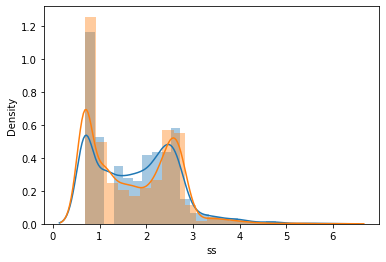

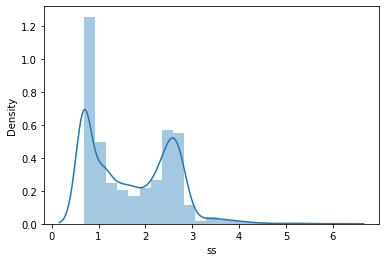

In [121]:
plt.figure()

sns.distplot(a2.ss)
sns.distplot(b2.ss)
plt.show()

plt.figure()
sns.distplot(b2.ss)
plt.show()

In [ ]:
sns.distplot(b2.ss)

1


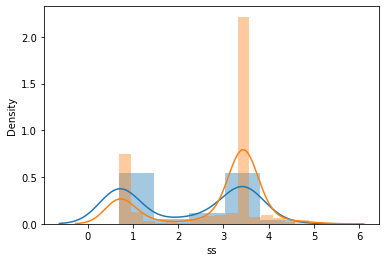

2


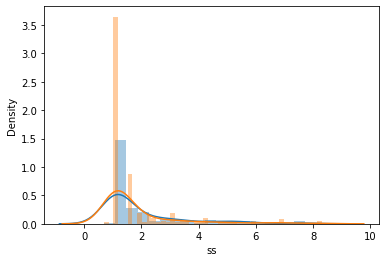

3


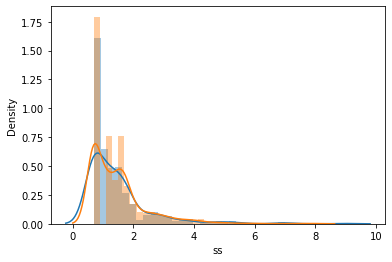

4


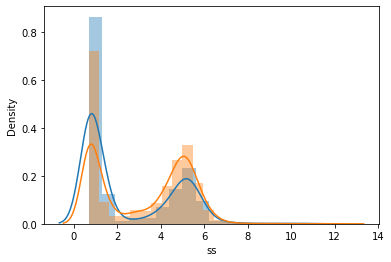

5


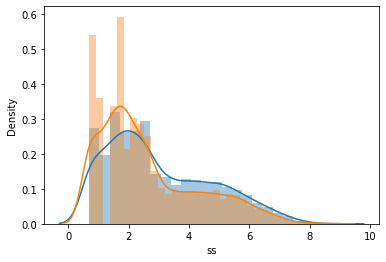

6


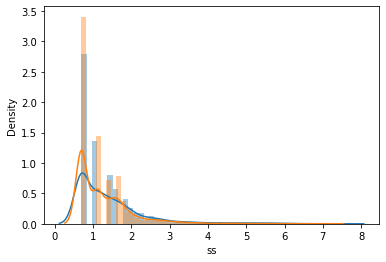

7


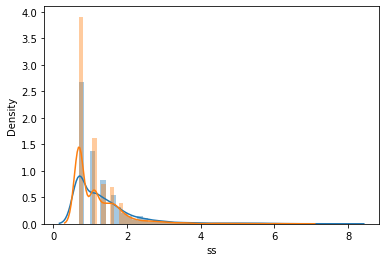

8


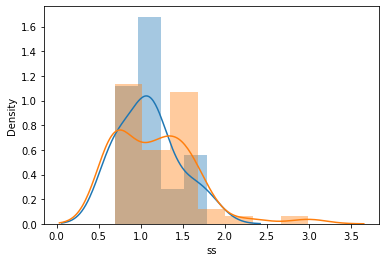

9


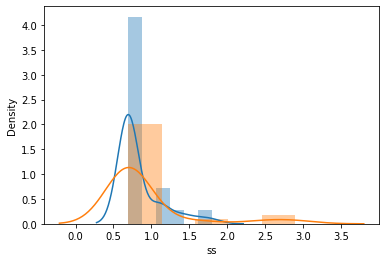

10


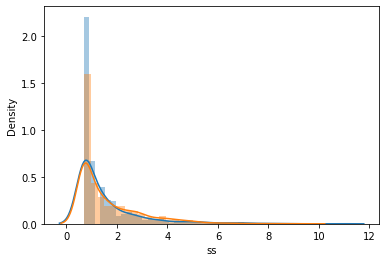

11


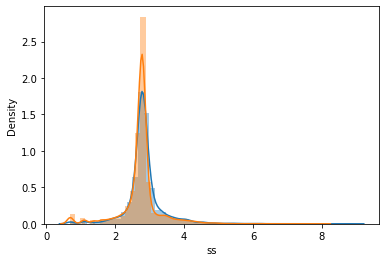

12


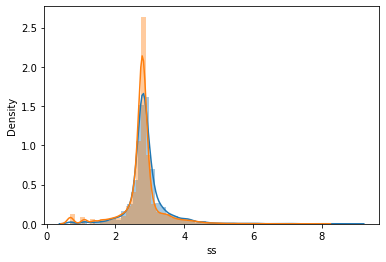

13


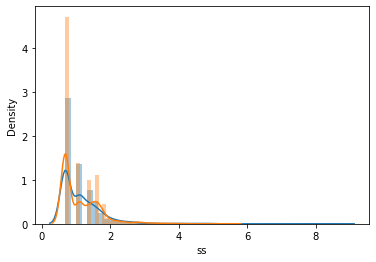

14


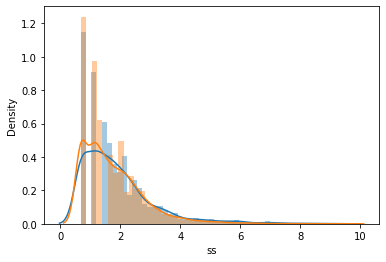

15


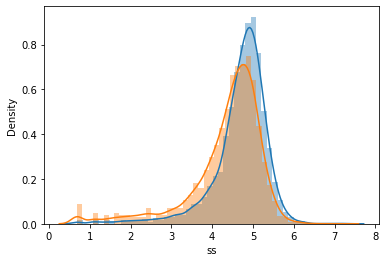

16


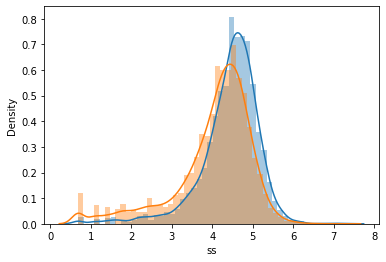

17


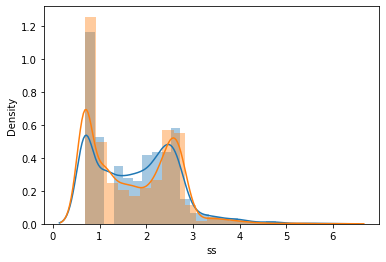

18


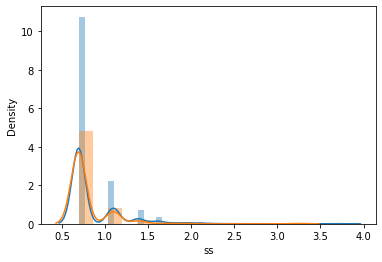

19


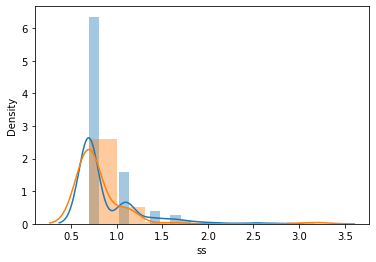

20


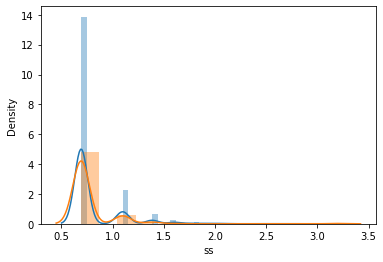

21


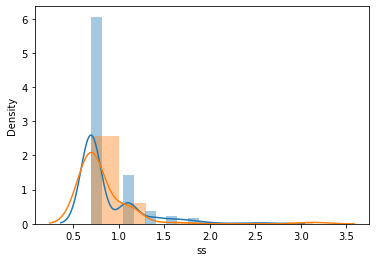

22


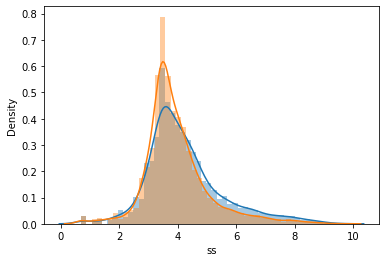

23


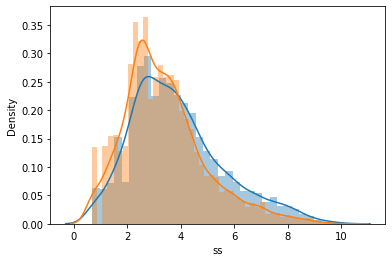

24


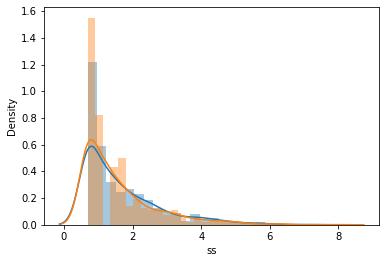

25


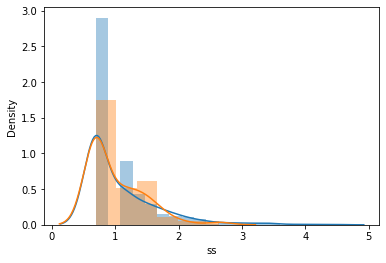

26


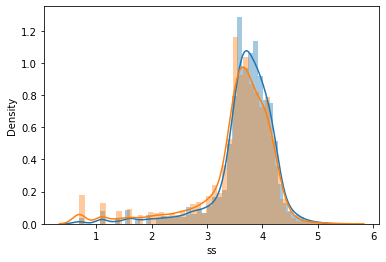

27


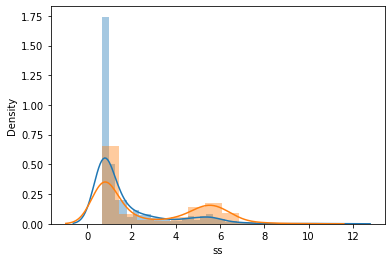

28


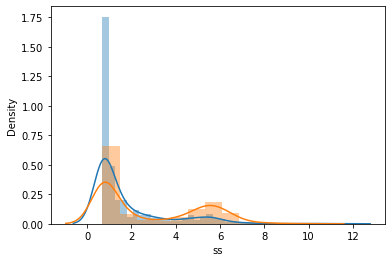

30


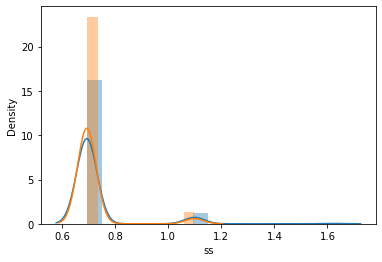

31


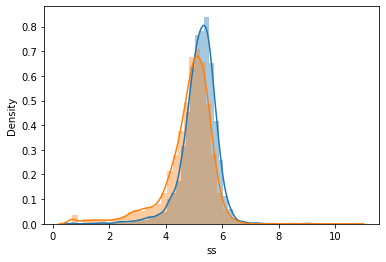

32


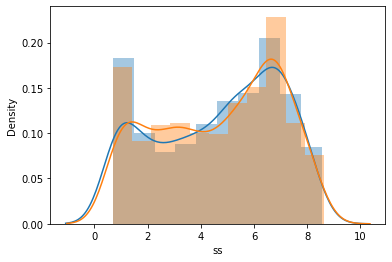

33


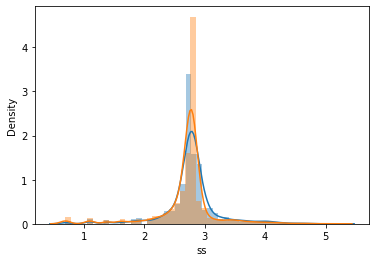

34


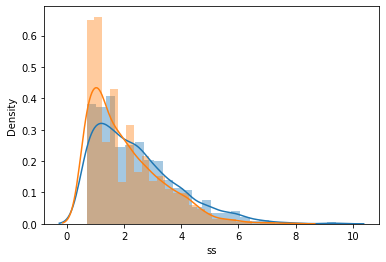

35


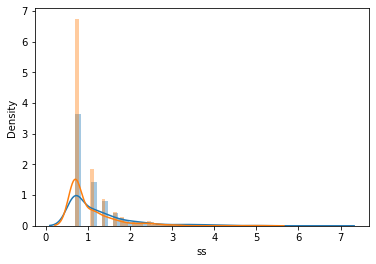

36


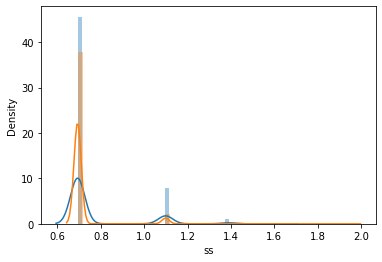

37


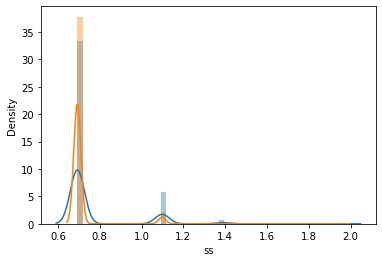

38


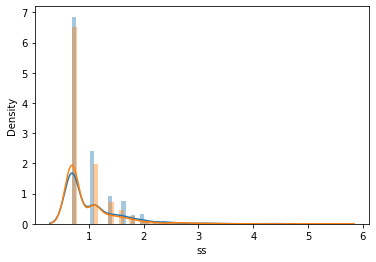

39


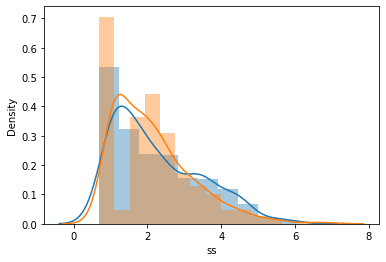

40


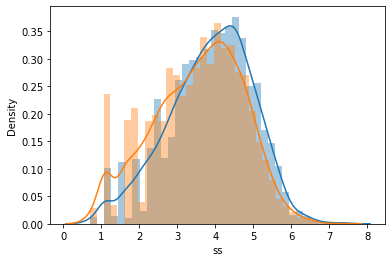

41


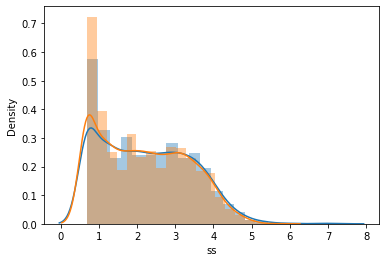

42


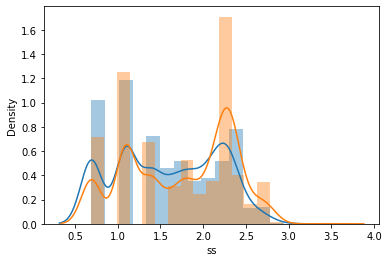

In [123]:
errs = train_err3['errtype'].unique()
errs.sort()

for err in errs:
  ts = train_err3[train_err3['errtype'] == err]
  ts['ss'] = 1
  tt = ts.groupby(by = 'user_id').sum()
  
  tt = np.log(tt + 1)
  tt['prob'] = tt.index.isin(prob_list)
  tt = tt[['ss', 'prob']]

  tt_tr = tt[tt['prob']]
  tt_fls = tt[~tt['prob']]
  plt.figure()
  sns.distplot(tt_tr.ss)
  sns.distplot(tt_fls.ss)
  print(err)
  plt.show()


In [135]:
a = train_err2.errcode.unique()
b = test_err2.errcode.unique()

In [140]:
len(b)

2956

In [138]:
len([x for x in b if x not in a])

1549

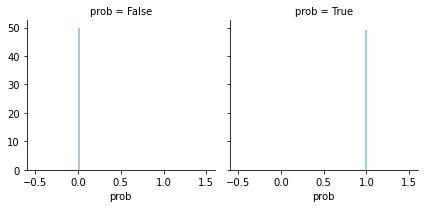

In [105]:
g = sns.FacetGrid(tt, col = 'prob')
g.map(sns.distplot, 'prob')

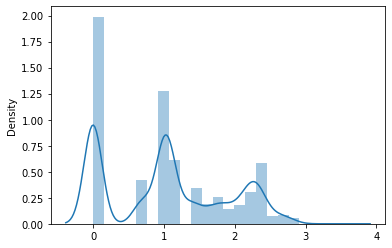

In [106]:
sns.distplot(tt)

In [60]:
# tuned_cat = tune_model(cat, optimize='AUC')

# 앙상블로 예측하고 싶으면 model = final_model, 캣부로 해보고 싶으면 model = tuned_cat
model = cat

# predictions = predict_model(model, data = testset2)
df = pd.DataFrame(model.feature_importances_, index = model.feature_names_, columns = ['feature'])
df = df.reset_index()
df.to_csv("F_impo2.csv", index = False)
!cp F_impo2.csv "drive/My Drive/"

In [45]:
X = trainset3.iloc[:,:-1]
y = trainset3.iloc[:,-1]

In [60]:
clf = CatBoostClassifier(task_type = 'GPU', verbose = 1000, cat_features = ['fw_update', 'Group'])#iterations=3000, task_type = 'GPU', use_best_model = True, cat_features = ['fw_update', 'Group'])

In [61]:
skf = StratifiedKFold(n_splits=10)
scores = cross_val_score(clf, X, y, cv = skf, scoring='roc_auc')

Learning rate set to 0.029215
0:	learn: 0.6812193	total: 54.6ms	remaining: 54.5s
999:	learn: 0.3802578	total: 46.9s	remaining: 0us
Learning rate set to 0.029215
0:	learn: 0.6812721	total: 50ms	remaining: 49.9s
999:	learn: 0.3816094	total: 47.1s	remaining: 0us
Learning rate set to 0.029215
0:	learn: 0.6812238	total: 47.9ms	remaining: 47.8s
999:	learn: 0.3883889	total: 46.8s	remaining: 0us
Learning rate set to 0.029215
0:	learn: 0.6813045	total: 50.1ms	remaining: 50s
999:	learn: 0.3829991	total: 47s	remaining: 0us
Learning rate set to 0.029215
0:	learn: 0.6813301	total: 48.8ms	remaining: 48.7s
999:	learn: 0.3855769	total: 46.5s	remaining: 0us
Learning rate set to 0.029215
0:	learn: 0.6814753	total: 47.8ms	remaining: 47.7s
999:	learn: 0.3901016	total: 46.5s	remaining: 0us
Learning rate set to 0.029215
0:	learn: 0.6812682	total: 49.8ms	remaining: 49.8s
999:	learn: 0.3871922	total: 46.6s	remaining: 0us
Learning rate set to 0.029215
0:	learn: 0.6812802	total: 48.7ms	remaining: 48.7s
999:	lea

In [63]:
scores.mean()

0.8239181999999999

In [ ]:
x = []
for i in range(len(predictions['Score'])):
  if predictions['Label'][i+30000] ==1:
    x.append(predictions['Score'][i+30000])
  else:
    x.append(1-predictions['Score'][i+30000])

In [ ]:
sample_submssion = pd.read_csv('/content/drive/Shareddrives/dacon/404/sample_submission.csv')
sample_submssion['problem'] = x
sample_submssion.to_csv("CAT.csv", index = False)
!cp CAT.csv "drive/My Drive/"

In [ ]:
sample_submssion

,user_id,problem
0,30000,0.957976
1,30001,0.325178
2,30002,0.509332
3,30003,0.908938
4,30004,0.768151
...,...,...
14994,44994,0.180381
14995,44995,0.398818
14996,44996,0.695316
14997,44997,0.943637
